In [3]:
# import
import os
import pandas as pd
import numpy as np
import nibabel as nib
import shutil
from scipy.ndimage import zoom
from joblib import Parallel, delayed
from tqdm import tqdm
import psutil
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report,precision_recall_curve,roc_curve,accuracy_score

from IPython.display import display,clear_output
import cv2

In [4]:
#nii 파일 로드 + 전처리 함수들
# NIfTI 파일 로드
def load_nii(file_path):
    try:
        data = nib.load(file_path).get_fdata(dtype=np.float64)
        if data.ndim == 4 and data.shape[-1] == 1:
            data = data.squeeze(axis=-1)
        elif data.ndim != 3:
            raise ValueError(f"Unexpected data dimensions: {data.shape}. Expected 3D data.")
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

# PyTorch 기반 리사이즈 함수
def resize_volume_torch(volume, target_shape=(120, 120, 120)):
    try:
        volume_tensor = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        resized = F.interpolate(volume_tensor, size=target_shape, mode='trilinear', align_corners=False)
        return resized.squeeze().numpy()
    except Exception as e:
        print(f"Error resizing volume: {e}")
        return None

# 단일 파일 처리
def process_file(file_name, mmse_score, base_path, target_shape):
    file_path = os.path.join(base_path, file_name)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    volume = load_nii(file_path)
    if volume is None:
        return None

    resized_volume = resize_volume_torch(volume, target_shape)
    if resized_volume is None:
        return None

    return [resized_volume, mmse_score]

# 데이터셋 생성 - Chunking + 병렬 처리
def create_dataset(dataset, base_path, target_shape=(128, 128, 128), chunk_size=20):
    processed_data = []
    total_chunks = len(dataset) // chunk_size + (1 if len(dataset) % chunk_size != 0 else 0)

    # tqdm으로 진행 상황 표시
    with tqdm(total=total_chunks, desc="Processing Dataset") as pbar:
        for i in range(0, len(dataset), chunk_size):
            chunk = dataset[i:i + chunk_size]
            # 병렬 처리
            processed_chunk = Parallel(n_jobs=4)(
                delayed(process_file)(file_name, mmse_score, base_path, target_shape) for file_name, mmse_score in chunk
            )
            # 유효한 데이터만 추가
            processed_data.extend([item for item in processed_chunk if item is not None])
            # 메모리 디버깅 함수
            # print(f"{psutil.virtual_memory().percent}%")
            # Progress bar 업데이트
            pbar.update(1)
    return processed_data

In [4]:
#file 받아오고 처리하는 함수들
def get_file_list(folder_path, extension=None):
    try:
        file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and (not extension or f.endswith(extension))]
        return file_list
    except Exception as e:
        print(f"Error getting file list from {folder_path}: {e}")
        return []

def rename_and_copy_files(folder_path, target_folder, extension=None):
    try:
        # 대상 폴더 생성
        os.makedirs(target_folder, exist_ok=True)
        file_list = get_file_list(folder_path, extension)
        for file_name in file_list:
            # 날짜 제거를 위한 파일 이름 분리
            parts = file_name.split(",")
            if len(parts) == 3:
                new_name = f"{parts[0]},{parts[2]}"
                old_path = os.path.join(folder_path, file_name)
                new_path = os.path.join(target_folder, new_name)
                shutil.copy(old_path, new_path)
                print(f"Copied and Renamed: {old_path} -> {new_path}")
    except Exception as e:
        print(f"파일 이름 변경 및 복사 중 에러 발생: {e}")

In [10]:
#renamed 폴더로 이름에 환자번호 - mri번호만 남김 - 날짜 없는 파일에 대한 처리
# folder_path = "niis/ADNI4"
# target_folder = "niis/ADNI4_renamed" 
# extension = ".gz" 
# rename_and_copy_files(folder_path, target_folder, extension)

In [3]:
def load_metadata_and_files(file_list, metadata, metadata_columns):
    dataset = []
    for file in file_list:
        f = file
        file_parts = file.split('.')[0].split(',')
        if len(file_parts) < 2:
            print(f"Invalid file format: {file}")
            continue
        
        mmse = metadata.loc[
            (metadata[metadata_columns[0]] == file_parts[0]) &
            (metadata[metadata_columns[1]] == file_parts[1]), 
            'MMSCORE'
        ]
        
        mmse_value = mmse.values[0] if not mmse.empty else None
        if mmse_value is not None:
            dataset.append([f, mmse_value])
        else:
            pass
            # print(f"No matching MMSE score for file: {file}")
    
    return dataset

In [12]:
# 경로 및 데이터 설정
adni3_base_path = 'niis/ADNI3_renamed'
adni4_base_path = 'niis/ADNI4_renamed'

adni3_metadata = pd.read_csv('metadatas/adni3_metadata_cleaned.csv')
adni4_metadata = pd.read_csv('metadatas/adni4_metadata_cleaned.csv')

adni3_file_list = get_file_list(adni3_base_path, extension='.nii.gz')
adni4_file_list = get_file_list(adni4_base_path, extension='.nii.gz')

adni3_dataset = load_metadata_and_files(adni3_file_list, adni3_metadata, ['PTID', 'MRI Number'])
adni4_dataset = load_metadata_and_files(adni4_file_list, adni4_metadata, ['PTID', 'MRI Number'])

In [4]:
# 데이터셋 생성
target_shape = (128, 128, 128)
print(adni3_dataset[0])

train_dataset = create_dataset(adni3_dataset, adni3_base_path, target_shape)
test_dataset = create_dataset(adni4_dataset, adni4_base_path, target_shape)
# 디버깅용 출력
for volume, score in train_dataset[:5]:
    print(f"Volume shape: {volume.shape}, MMSE Score: {score}")

NameError: name 'adni3_dataset' is not defined

(256, 256, 256)


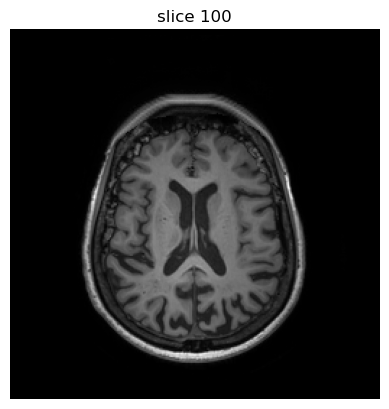

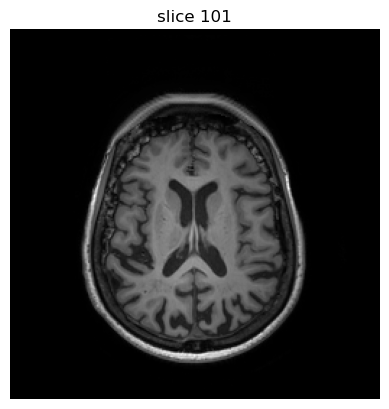

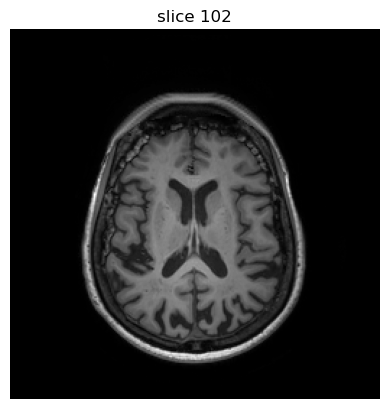

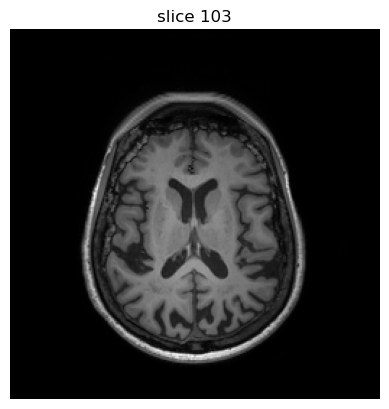

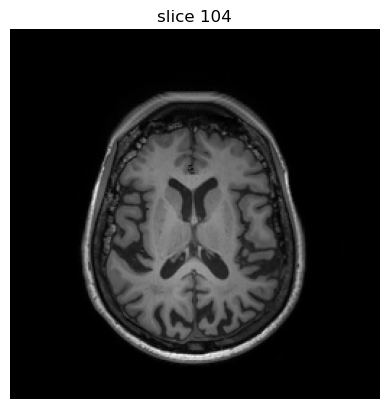

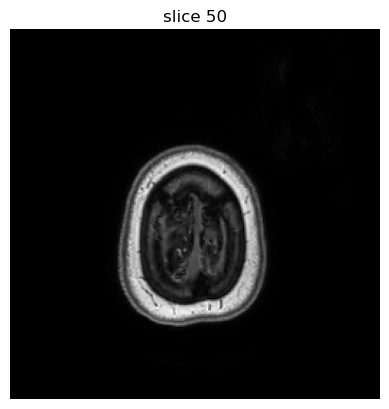

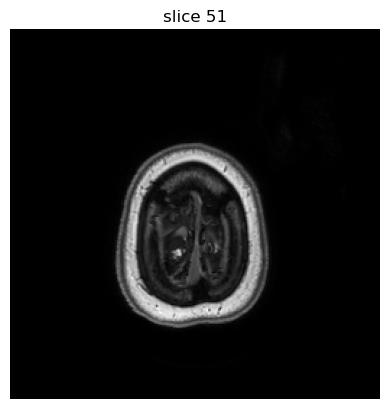

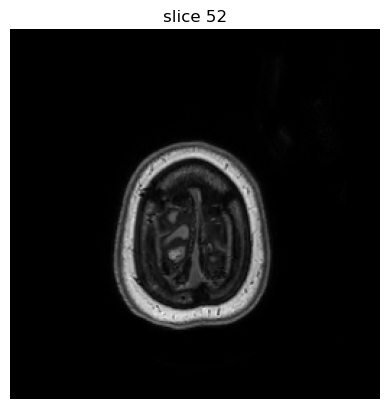

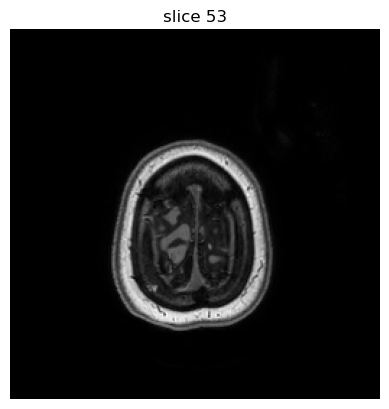

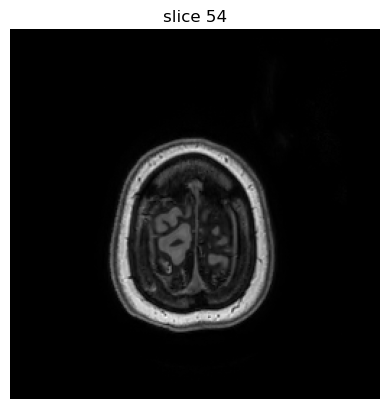

In [8]:

nii_data=load_nii('./niis/ADNI4/301_S_10194,I10913996.nii.gz')
print(nii_data.shape)
for i in range(5):
    slice_data = nii_data[100+i,:,:]
    plt.imshow(slice_data,cmap='gray')
    plt.title(f"slice {100+i}")
    plt.axis('off')
    plt.show()
data = nib.load('./niis/ADNI4/301_S_10194,I10913996.nii.gz')    

nii_data_resized=resize_volume_torch(nii_data)
ni_img = nib.Nifti1Image(nii_data_resized, data.affine)
nib.save(ni_img,'2024-08-09,I10913996_resized.nii.gz')

for i in range(5):
    slice_data = nii_data[50+i,:,:]
    plt.imshow(slice_data,cmap='gray')
    plt.title(f"slice {50+i}")
    plt.axis('off')
    plt.show()